In [1]:
import sys
import time

TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output

In [2]:
from torch.utils import data as data
from torchvision import transforms
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import os
from astropy.io import fits
from skimage.transform import resize
import numpy as np

IMG_EXTENSIONS = [".fits"]

def input_transform():
    return Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,), (1500,))
    ])

def target_transform():
    return Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,), (1500,))
    ])

def is_image_file(filename):
    """
    Helper Function to determine whether a file is an image file or not
    :param filename: the filename containing a possible image
    :return: True if file is image file, False otherwise
    """
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir):
    """
    Helper Function to make a dataset containing all images in a certain directory
    :param dir: the directory containing the dataset
    :return: images: list of image paths
    """
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images


def default_fits_loader(file_name: str, img_size: tuple):
    file = fits.open(file_name)
    if np.all(file[0].data) == None:
        _data = file[1].data
    else:
        _data = file[0].data
#    _data[_data != _data] = 0 
    _data = resize(_data, img_size)
    
    # _data = fits.get_data(file_name).resize(img_size)

    # add channels
    if len(_data.shape) < 3:
        _data = _data.reshape((*_data.shape,1))
    # TODO: Insert Custom Label Loader
    _target = _data
#    print(np.nanmax(_data))
    return _data, _target


class FITSDataset(data.Dataset):
    def __init__(self, data_path, input_transform, target_transform, img_size):
        self.data_path = data_path
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.img_size = img_size

        self.img_files = make_dataset(data_path)

    def __getitem__(self, index):
        _img, _target = default_fits_loader(self.img_files[index], self.img_size)
        _img = np.clip(_img,-1500,1500)
        _img = _img[1024:3072, 1024:3072]
#        print(np.nanmax(_img))
        _target = np.clip(_target,-1500,1500)
        _target = _target[1024:3072, 1024:3072]
#        print(np.nanmax(_target))
        _img = resize(_img, (1024, 1024),preserve_range=True,anti_aliasing=True)
#        print(np.nanmax(_img))
#        print(np.nanmin(_img))
        if self.input_transform:
            _img = self.input_transform(_img)
            _img[_img != _img] = -1
        if self.target_transform:
            _target = self.target_transform(_target)
            _target[_target != _target] = -1
        _data = (_img, _target)
        
        return _data

    def __len__(self):
        return len(self.img_files)

scale = 4
train_dataset = FITSDataset("/home/mhabeeb2/data/HMI.fits/train", input_transform(),target_transform(),(1024*scale,1024*scale))
test_dataset = FITSDataset("/home/mhabeeb2/data/HMI.fits/test", input_transform(),target_transform(),(1024*scale,1024*scale))
training_data_loader = data.DataLoader(train_dataset, num_workers=2, batch_size=4, shuffle=True)
testing_data_loader = data.DataLoader(test_dataset, num_workers=2, batch_size=4, shuffle=False)

In [3]:
for batch_num, (data, target) in enumerate(training_data_loader):
    print(data.shape)
    print(target.shape)
#    print(data)
    print(np.nanmin(data))
    print(np.nanmax(data))
    break
for batch_num, (data, target) in enumerate(testing_data_loader):
    print(data.shape)
    print(target.shape)
    print(np.nanmax(data))
    break

torch.Size([4, 1, 1024, 1024])
torch.Size([4, 1, 2048, 2048])
-0.9999999998665525
0.9999942610625195
torch.Size([4, 1, 1024, 1024])
torch.Size([4, 1, 2048, 2048])
1.0


# SRCNN

In [4]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

# Residual Net

In [4]:
import torch.nn as nn
import torch.nn.init as init
from math import log10
class Net(nn.Module):
    def __init__(self, num_channels, base_channel, upscale_factor, num_residuals):
        super(Net, self).__init__()

        self.input_conv = nn.Conv2d(num_channels, base_channel, kernel_size=3, stride=1, padding=1)

        resnet_blocks = []
        for _ in range(num_residuals):
            resnet_blocks.append(ResnetBlock(base_channel, kernel=3, stride=1, padding=1))
        self.residual_layers = nn.Sequential(*resnet_blocks)

        self.mid_conv = nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, padding=1)

        upscale = []
        for _ in range(int(math.log2(upscale_factor))):
            upscale.append(PixelShuffleBlock(base_channel, base_channel, upscale_factor=2))
        self.upscale_layers = nn.Sequential(*upscale)

        self.output_conv = nn.Conv2d(base_channel, num_channels, kernel_size=3, stride=1, padding=1)

    def weight_init(self, mean=0.0, std=0.02):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        x = self.input_conv(x)
        residual = x
        x = self.residual_layers(x)
        x = self.mid_conv(x)
        x = torch.add(x, residual)
        x = self.upscale_layers(x)
        x = self.output_conv(x)
        return x


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        if m.bias is not None:
            m.bias.data.zero_()


class ResnetBlock(nn.Module):
    def __init__(self, num_channel, kernel=3, stride=1, padding=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, num_channel, kernel, stride, padding)
        self.conv2 = nn.Conv2d(num_channel, num_channel, kernel, stride, padding)
        self.bn = nn.BatchNorm2d(num_channel)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.bn(self.conv1(x))
        x = self.activation(x)
        x = self.bn(self.conv2(x))
        x = torch.add(x, residual)
        return x


class PixelShuffleBlock(nn.Module):
    def __init__(self, in_channel, out_channel, upscale_factor, kernel=3, stride=1, padding=1):
        super(PixelShuffleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel * upscale_factor ** 2, kernel, stride, padding)
        self.ps = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.ps(self.conv(x))
        return x

# Deep Recursive NN

In [19]:
import torch
import torch.nn as nn


class Net(torch.nn.Module):
    def __init__(self, num_channels, base_channel, num_recursions, device):
        super(Net, self).__init__()
        self.num_recursions = num_recursions
        self.embedding_layer = nn.Sequential(
            nn.Conv2d(num_channels, base_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        self.conv_block = nn.Sequential(nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True))

        self.reconstruction_layer = nn.Sequential(
            nn.Conv2d(base_channel, base_channel, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(base_channel, num_channels, kernel_size=3, stride=1, padding=1)
        )

        self.w_init = torch.ones(self.num_recursions) / self.num_recursions
        self.w = self.w_init.to(device)

    def forward(self, x):
        h0 = self.embedding_layer(x)

        h = [h0]
        for d in range(self.num_recursions):
            h.append(self.conv_block(h[d]))

        y_d_ = list()
        out_sum = 0
        for d in range(self.num_recursions):
            y_d_.append(self.reconstruction_layer(h[d+1]))
            out_sum += torch.mul(y_d_[d], self.w[d])
        out_sum = torch.mul(out_sum, 1.0 / (torch.sum(self.w)))

        final_out = torch.add(out_sum, x)

        return y_d_, final_out

    def weight_init(self):
        for m in self._modules:
            weights_init_kaiming(m)


def weights_init_kaiming(m):
    class_name = m.__class__.__name__
    if class_name.find('Linear') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()
    elif class_name.find('Conv2d') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()
    elif class_name.find('ConvTranspose2d') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()
    elif class_name.find('Norm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        if m.bias is not None:
            m.bias.data.zero_()

# Deep Back Propagation

In [25]:
import torch
import math
import torch.nn as nn


class DBPN(nn.Module):
    def __init__(self, num_channels, base_channels, feat_channels, num_stages, scale_factor):
        super(DBPN, self).__init__()

        if scale_factor == 2:
            kernel_size = 6
            stride = 2
            padding = 2
        elif scale_factor == 4:
            kernel_size = 8
            stride = 4
            padding = 2
        elif scale_factor == 8:
            kernel_size = 12
            stride = 8
            padding = 2
        else:
            kernel_size = None
            stride = None
            padding = None
            Warning("please choose the scale factor from 2, 4, 8")
            exit()

        # Initial Feature Extraction
        self.feat0 = ConvBlock(num_channels, feat_channels, 3, 1, 1, activation='prelu', norm=None)
        self.feat1 = ConvBlock(feat_channels, base_channels, 1, 1, 0, activation='prelu', norm=None)
        # Back-projection stages
        self.up1 = UpBlock(base_channels, kernel_size, stride, padding)
        self.down1 = DownBlock(base_channels, kernel_size, stride, padding)
        self.up2 = UpBlock(base_channels, kernel_size, stride, padding)
        self.down2 = D_DownBlock(base_channels, kernel_size, stride, padding, 2)
        self.up3 = D_UpBlock(base_channels, kernel_size, stride, padding, 2)
        self.down3 = D_DownBlock(base_channels, kernel_size, stride, padding, 3)
        self.up4 = D_UpBlock(base_channels, kernel_size, stride, padding, 3)
        self.down4 = D_DownBlock(base_channels, kernel_size, stride, padding, 4)
        self.up5 = D_UpBlock(base_channels, kernel_size, stride, padding, 4)
        self.down5 = D_DownBlock(base_channels, kernel_size, stride, padding, 5)
        self.up6 = D_UpBlock(base_channels, kernel_size, stride, padding, 5)
        self.down6 = D_DownBlock(base_channels, kernel_size, stride, padding, 6)
        self.up7 = D_UpBlock(base_channels, kernel_size, stride, padding, 6)
        # Reconstruction
        self.output_conv = ConvBlock(num_stages * base_channels, num_channels, 3, 1, 1, activation=None, norm=None)

    def weight_init(self):
        for m in self._modules:
            class_name = m.__class__.__name__
            if class_name.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif class_name.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.feat0(x)
        x = self.feat1(x)

        h1 = self.up1(x)
        l1 = self.down1(h1)
        h2 = self.up2(l1)

        concat_h = torch.cat((h2, h1), 1)
        l = self.down2(concat_h)

        concat_l = torch.cat((l, l1), 1)
        h = self.up3(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down3(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up4(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down4(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up5(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down5(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up6(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down6(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up7(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        x = self.output_conv(concat_h)

        return x


class DBPNS(nn.Module):
    def __init__(self, num_channels, base_channels, feat_channels, num_stages, scale_factor):
        super(DBPNS, self).__init__()

        if scale_factor == 2:
            kernel_size = 6
            stride = 2
            padding = 2
        elif scale_factor == 4:
            kernel_size = 8
            stride = 4
            padding = 2
        elif scale_factor == 8:
            kernel_size = 12
            stride = 8
            padding = 2
        else:
            kernel_size = None
            stride = None
            padding = None
            Warning("please choose the scale factor from 2, 4, 8")
            exit()

        # Initial Feature Extraction
        self.feat0 = ConvBlock(num_channels, feat_channels, 3, 1, 1, activation='prelu', norm=None)
        self.feat1 = ConvBlock(feat_channels, base_channels, 1, 1, 0, activation='prelu', norm=None)
        # Back-projection stages
        self.up1 = UpBlock(base_channels, kernel_size, stride, padding)
        self.down1 = DownBlock(base_channels, kernel_size, stride, padding)
        self.up2 = UpBlock(base_channels, kernel_size, stride, padding)
        # Reconstruction
        self.output_conv = ConvBlock(num_stages * base_channels, num_channels, 3, 1, 1, activation=None, norm=None)

    def weight_init(self):
        for m in self._modules:
            class_name = m.__class__.__name__
            if class_name.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif class_name.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.feat0(x)
        x = self.feat1(x)

        h1 = self.up1(x)
        h2 = self.up2(self.down1(h1))

        x = self.output_conv(torch.cat((h2, h1), 1))

        return x


class DBPNLL(nn.Module):
    def __init__(self, num_channels, base_channels, feat_channels, num_stages, scale_factor):
        super(DBPNLL, self).__init__()

        if scale_factor == 2:
            kernel_size = 6
            stride = 2
            padding = 2
        elif scale_factor == 4:
            kernel_size = 8
            stride = 4
            padding = 2
        elif scale_factor == 8:
            kernel_size = 12
            stride = 8
            padding = 2
        else:
            kernel_size = None
            stride = None
            padding = None
            Warning("please choose the scale factor from 2, 4, 8")
            exit()

        # Initial Feature Extraction
        self.feat0 = ConvBlock(num_channels, feat_channels, 3, 1, 1, activation='prelu', norm=None)
        self.feat1 = ConvBlock(feat_channels, base_channels, 1, 1, 0, activation='prelu', norm=None)
        # Back-projection stages
        self.up1 = UpBlock(base_channels, kernel_size, stride, padding)
        self.down1 = DownBlock(base_channels, kernel_size, stride, padding)
        self.up2 = UpBlock(base_channels, kernel_size, stride, padding)
        self.down2 = D_DownBlock(base_channels, kernel_size, stride, padding, 2)
        self.up3 = D_UpBlock(base_channels, kernel_size, stride, padding, 2)
        self.down3 = D_DownBlock(base_channels, kernel_size, stride, padding, 3)
        self.up4 = D_UpBlock(base_channels, kernel_size, stride, padding, 3)
        self.down4 = D_DownBlock(base_channels, kernel_size, stride, padding, 4)
        self.up5 = D_UpBlock(base_channels, kernel_size, stride, padding, 4)
        self.down5 = D_DownBlock(base_channels, kernel_size, stride, padding, 5)
        self.up6 = D_UpBlock(base_channels, kernel_size, stride, padding, 5)
        self.down6 = D_DownBlock(base_channels, kernel_size, stride, padding, 6)
        self.up7 = D_UpBlock(base_channels, kernel_size, stride, padding, 6)
        self.down7 = D_DownBlock(base_channels, kernel_size, stride, padding, 7)
        self.up8 = D_UpBlock(base_channels, kernel_size, stride, padding, 7)
        self.down8 = D_DownBlock(base_channels, kernel_size, stride, padding, 8)
        self.up9 = D_UpBlock(base_channels, kernel_size, stride, padding, 8)
        self.down9 = D_DownBlock(base_channels, kernel_size, stride, padding, 9)
        self.up10 = D_UpBlock(base_channels, kernel_size, stride, padding, 9)
        # Reconstruction
        self.output_conv = ConvBlock(num_stages * base_channels, num_channels, 3, 1, 1, activation=None, norm=None)

    def weight_init(self):
        for m in self._modules:
            class_name = m.__class__.__name__
            if class_name.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif class_name.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.feat0(x)
        x = self.feat1(x)

        h1 = self.up1(x)
        l1 = self.down1(h1)
        h2 = self.up2(l1)

        concat_h = torch.cat((h2, h1), 1)
        l = self.down2(concat_h)

        concat_l = torch.cat((l, l1), 1)
        h = self.up3(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down3(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up4(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down4(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up5(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down5(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up6(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down6(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up7(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down7(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up8(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down8(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up9(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        l = self.down9(concat_h)

        concat_l = torch.cat((l, concat_l), 1)
        h = self.up10(concat_l)

        concat_h = torch.cat((h, concat_h), 1)
        x = self.output_conv(concat_h)

        return x


############################################################################################
# Base models
############################################################################################


class DenseBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, bias=True, activation='relu', norm='batch'):
        super(DenseBlock, self).__init__()
        self.fc = torch.nn.Linear(input_size, output_size, bias=bias)

        self.norm = norm
        if self.norm == 'batch':
            self.bn = torch.nn.BatchNorm1d(output_size)
        elif self.norm == 'instance':
            self.bn = torch.nn.InstanceNorm1d(output_size)

        self.activation = activation
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.fc(x))
        else:
            out = self.fc(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out


class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=1, bias=True, activation='prelu',
                 norm=None):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.norm = norm
        if self.norm == 'batch':
            self.bn = torch.nn.BatchNorm2d(output_size)
        elif self.norm == 'instance':
            self.bn = torch.nn.InstanceNorm2d(output_size)

        self.activation = activation
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, bias=True, activation='prelu',
                 norm=None):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.norm = norm
        if self.norm == 'batch':
            self.bn = torch.nn.BatchNorm2d(output_size)
        elif self.norm == 'instance':
            self.bn = torch.nn.InstanceNorm2d(output_size)

        self.activation = activation
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out


class ResnetBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=3, stride=1, padding=1, bias=True, activation='prelu', norm='batch'):
        super(ResnetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=bias)
        self.conv2 = torch.nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=bias)

        self.norm = norm
        if self.norm == 'batch':
            self.bn = torch.nn.BatchNorm2d(num_filter)
        elif norm == 'instance':
            self.bn = torch.nn.InstanceNorm2d(num_filter)

        self.activation = activation
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        residual = x
        if self.norm is not None:
            out = self.bn(self.conv1(x))
        else:
            out = self.conv1(x)

        if self.activation is not None:
            out = self.act(out)

        if self.norm is not None:
            out = self.bn(self.conv2(out))
        else:
            out = self.conv2(out)

        out = torch.add(out, residual)
        return out


class UpBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, bias=True, activation='prelu', norm=None):
        super(UpBlock, self).__init__()
        self.up_conv1 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.up_conv2 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.up_conv3 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)

    def forward(self, x):
        h0 = self.up_conv1(x)
        l0 = self.up_conv2(h0)
        h1 = self.up_conv3(l0 - x)
        return h1 + h0


class UpBlockPix(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, scale=4, bias=True, activation='prelu', norm=None):
        super(UpBlockPix, self).__init__()
        self.up_conv1 = Upsampler(scale, num_filter)
        self.up_conv2 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.up_conv3 = Upsampler(scale, num_filter)

    def forward(self, x):
        h0 = self.up_conv1(x)
        l0 = self.up_conv2(h0)
        h1 = self.up_conv3(l0 - x)
        return h1 + h0


class D_UpBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, num_stages=1, bias=True, activation='prelu',
                 norm=None):
        super(D_UpBlock, self).__init__()
        self.conv = ConvBlock(num_filter * num_stages, num_filter, 1, 1, 0, activation=activation, norm=None)
        self.up_conv1 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.up_conv2 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.up_conv3 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)

    def forward(self, x):
        x = self.conv(x)
        h0 = self.up_conv1(x)
        l0 = self.up_conv2(h0)
        h1 = self.up_conv3(l0 - x)
        return h1 + h0


class D_UpBlockPix(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, num_stages=1, scale=4, bias=True,
                 activation='prelu', norm=None):
        super(D_UpBlockPix, self).__init__()
        self.conv = ConvBlock(num_filter * num_stages, num_filter, 1, 1, 0, activation=activation, norm=None)
        self.up_conv1 = Upsampler(scale, num_filter)
        self.up_conv2 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.up_conv3 = Upsampler(scale, num_filter)

    def forward(self, x):
        x = self.conv(x)
        h0 = self.up_conv1(x)
        l0 = self.up_conv2(h0)
        h1 = self.up_conv3(l0 - x)
        return h1 + h0


class DownBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, bias=True, activation='prelu', norm=None):
        super(DownBlock, self).__init__()
        self.down_conv1 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.down_conv2 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.down_conv3 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)

    def forward(self, x):
        l0 = self.down_conv1(x)
        h0 = self.down_conv2(l0)
        l1 = self.down_conv3(h0 - x)
        return l1 + l0


class DownBlockPix(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, scale=4, bias=True, activation='prelu',
                 norm=None):
        super(DownBlockPix, self).__init__()
        self.down_conv1 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.down_conv2 = Upsampler(scale, num_filter)
        self.down_conv3 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)

    def forward(self, x):
        l0 = self.down_conv1(x)
        h0 = self.down_conv2(l0)
        l1 = self.down_conv3(h0 - x)
        return l1 + l0


class D_DownBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, num_stages=1, bias=True, activation='prelu',
                 norm=None):
        super(D_DownBlock, self).__init__()
        self.conv = ConvBlock(num_filter * num_stages, num_filter, 1, 1, 0, activation=activation, norm=None)
        self.down_conv1 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.down_conv2 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.down_conv3 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)

    def forward(self, x):
        x = self.conv(x)
        l0 = self.down_conv1(x)
        h0 = self.down_conv2(l0)
        l1 = self.down_conv3(h0 - x)
        return l1 + l0


class D_DownBlockPix(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, num_stages=1, scale=4, bias=True,
                 activation='prelu', norm=None):
        super(D_DownBlockPix, self).__init__()
        self.conv = ConvBlock(num_filter * num_stages, num_filter, 1, 1, 0, activation=activation, norm=None)
        self.down_conv1 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)
        self.down_conv2 = Upsampler(scale, num_filter)
        self.down_conv3 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation=activation, norm=None)

    def forward(self, x):
        x = self.conv(x)
        l0 = self.down_conv1(x)
        h0 = self.down_conv2(l0)
        l1 = self.down_conv3(h0 - x)
        return l1 + l0


class PSBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, scale_factor, kernel_size=3, stride=1, padding=1, bias=True,
                 activation='prelu', norm='batch'):
        super(PSBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size * scale_factor ** 2, kernel_size, stride, padding,
                                    bias=bias)
        self.ps = torch.nn.PixelShuffle(scale_factor)

        self.norm = norm
        if self.norm == 'batch':
            self.bn = torch.nn.BatchNorm2d(output_size)
        elif norm == 'instance':
            self.bn = torch.nn.InstanceNorm2d(output_size)

        self.activation = activation
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.ps(self.conv(x)))
        else:
            out = self.ps(self.conv(x))

        if self.activation is not None:
            out = self.act(out)
        return out


class Upsampler(torch.nn.Module):
    def __init__(self, scale, n_feat, bn=False, act='prelu', bias=True):
        super(Upsampler, self).__init__()
        modules = []
        for _ in range(int(math.log(scale, 2))):
            modules.append(ConvBlock(n_feat, 4 * n_feat, 3, 1, 1, bias, activation=None, norm=None))
            modules.append(torch.nn.PixelShuffle(2))
            if bn:
                modules.append(torch.nn.BatchNorm2d(n_feat))
            # modules.append(torch.nn.PReLU())
        self.up = torch.nn.Sequential(*modules)

        self.activation = act
        if self.activation == 'relu':
            self.act = torch.nn.ReLU(True)
        elif self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'tanh':
            self.act = torch.nn.Tanh()
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.up(x)
        if self.activation is not None:
            out = self.act(out)
        return out


class Upsample2xBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, bias=True, upsample='deconv', activation='relu', norm='batch'):
        super(Upsample2xBlock, self).__init__()
        scale_factor = 2
        # 1. Deconvolution (Transposed convolution)
        if upsample == 'deconv':
            self.upsample = DeconvBlock(input_size, output_size,
                                        kernel_size=4, stride=2, padding=1,
                                        bias=bias, activation=activation, norm=norm)

        # 2. Sub-pixel convolution (Pixel shuffler)
        elif upsample == 'ps':
            self.upsample = PSBlock(input_size, output_size, scale_factor=scale_factor,
                                    bias=bias, activation=activation, norm=norm)

        # 3. Resize and Convolution
        elif upsample == 'rnc':
            self.upsample = torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=scale_factor, mode='nearest'),
                ConvBlock(input_size, output_size,
                          kernel_size=3, stride=1, padding=1,
                          bias=bias, activation=activation, norm=norm)
            )

    def forward(self, x):
        out = self.upsample(x)
        return out

# SRGAN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def swish(x):
    return x * F.sigmoid(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel, out_channels, stride):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=kernel // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel, stride=stride, padding=kernel // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = swish(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x


class UpsampleBlock(nn.Module):
    # Implements resize-convolution
    def __init__(self, in_channels):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * 4, kernel_size=3, stride=1, padding=1)
        self.shuffler = nn.PixelShuffle(2)

    def forward(self, x):
        return swish(self.shuffler(self.conv(x)))


class Generator(nn.Module):
    def __init__(self, n_residual_blocks, upsample_factor, num_channel=1, base_filter=64):
        super(Generator, self).__init__()
        self.n_residual_blocks = n_residual_blocks
        self.upsample_factor = upsample_factor

        self.conv1 = nn.Conv2d(num_channel, base_filter, kernel_size=9, stride=1, padding=4)

        for i in range(self.n_residual_blocks):
            self.add_module('residual_block' + str(i + 1), ResidualBlock(in_channels=base_filter, out_channels=base_filter, kernel=3, stride=1))

        self.conv2 = nn.Conv2d(base_filter, base_filter, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filter)

        for i in range(self.upsample_factor // 2):
            self.add_module('upsample' + str(i + 1), UpsampleBlock(base_filter))

        self.conv3 = nn.Conv2d(base_filter, num_channel, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = swish(self.conv1(x))

        y = x.clone()
        for i in range(self.n_residual_blocks):
            y = self.__getattr__('residual_block' + str(i + 1))(y)

        x = self.bn2(self.conv2(y)) + x

        for i in range(self.upsample_factor // 2):
            x = self.__getattr__('upsample' + str(i + 1))(x)

        return self.conv3(x)

    def weight_init(self, mean=0.0, std=0.02):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


class Discriminator(nn.Module):
    def __init__(self, num_channel=1, base_filter=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, base_filter, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(base_filter, base_filter, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filter)
        self.conv3 = nn.Conv2d(base_filter, base_filter * 2, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filter * 2)
        self.conv4 = nn.Conv2d(base_filter * 2, base_filter * 2, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filter * 2)
        self.conv5 = nn.Conv2d(base_filter * 2, base_filter * 4, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(base_filter * 4)
        self.conv6 = nn.Conv2d(base_filter * 4, base_filter * 4, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(base_filter * 4)
        self.conv7 = nn.Conv2d(base_filter * 4, base_filter * 8, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(base_filter * 8)
        self.conv8 = nn.Conv2d(base_filter * 8, base_filter * 8, kernel_size=3, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(base_filter * 8)

        # Replaced original paper FC layers with FCN
        self.conv9 = nn.Conv2d(base_filter * 8, num_channel, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = swish(self.conv1(x))

        x = swish(self.bn2(self.conv2(x)))
        x = swish(self.bn3(self.conv3(x)))
        x = swish(self.bn4(self.conv4(x)))
        x = swish(self.bn5(self.conv5(x)))
        x = swish(self.bn6(self.conv6(x)))
        x = swish(self.bn7(self.conv7(x)))
        x = swish(self.bn8(self.conv8(x)))

        x = self.conv9(x)
        return torch.sigmoid(F.avg_pool2d(x, x.size()[2:])).view(x.size()[0], -1)

    def weight_init(self, mean=0.0, std=0.02):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# GAN Implementation PreTrain

In [ ]:
from __future__ import print_function
from math import log10
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.vgg import vgg16

netG = Generator(n_residual_blocks=16, upsample_factor=4, base_filter=64, num_channel=1)
netD = Discriminator(base_filter=64, num_channel=1)
feature_extractor = vgg16(pretrained=True)
netG.weight_init(mean=0.0, std=0.2)
netD.weight_init(mean=0.0, std=0.2)
criterionG = nn.MSELoss()
criterionD = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerD = optim.SGD(netD.parameters(), lr=0.001 / 100, momentum=0.9, nesterov=True)
for batch_num, (data, target) in enumerate(training_data_loader):
    data, target = data.float(), target.float()
    netG.zero_grad()
    loss = criterionG(netG(data), target)
    loss.backward()
    optimizerG.step()

/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Final Training

In [ ]:
def train():
    g_train_loss = 0
    d_train_loss = 0
    netG.train()
    netD.train()
    for batch_num, (data, target) in enumerate(training_data_loader):
        data, target = data.float(), target.float()
        # setup noise
        real_label = torch.ones(data.size(0), data.size(1))
        fake_label = torch.zeros(data.size(0), data.size(1))
    #    data, target = data.to(self.device), target.to(self.device)

        # Train Discriminator
        optimizerD.zero_grad()
        d_real = netD(target)
        d_real_loss = criterionD(d_real, real_label)

        d_fake = netD(netG(data))
        d_fake_loss = criterionD(d_fake, fake_label)
        d_total = d_real_loss + d_fake_loss
        d_train_loss += d_total.item()
        d_total.backward()
        optimizerD.step()

        # Train generator
        optimizerG.zero_grad()
        g_real = netG(data)
        g_fake = netD(g_real)
        gan_loss = criterionD(g_fake, real_label)
        mse_loss = criterionG(g_real, target)

        g_total = mse_loss + 1e-3 * gan_loss
        g_train_loss += g_total.item()
        g_total.backward()
        optimizerG.step()

        progress_bar(batch_num, len(training_data_loader), 'G_Loss: %.4f | D_Loss: %.4f' % (g_train_loss / (batch_num + 1), d_train_loss / (batch_num + 1)))

    print("    Average G_Loss: {:.4f}".format(g_train_loss / len(training_data_loader)))

def test():
    netG.eval()
    avg_psnr = 0

    with torch.  no_grad():
        for batch_num, (data, target) in enumerate(testing_data_loader):
            data, target = data.float(), target.float()
            prediction = netG(data)
            mse = criterionG(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
            progress_bar(batch_num, len(testing_data_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

    print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
for epoch in range(1, 2):
    train()
    test()

In [20]:
import math
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import torch
import torch.nn as nn
from math import log10
#DBPN
#model = DBPN(num_channels=1, base_channels=64, feat_channels=256, num_stages=7,scale_factor=4)
Residual Net
model = Net(num_channels=1, upscale_factor=4, base_channel=64, num_residuals=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#model.weight_init(mean=0.0, std=0.01)
criterion = torch.nn.MSELoss()
avg_psnr = 0
for batch_num, (data, target) in enumerate(training_data_loader):
    mse = criterion(model(data.float()), target)
    psnr = 10 * log10(1 / mse.item())
    avg_psnr += psnr
    progress_bar(batch_num, len(training_data_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(training_data_loader)))

IndentationError: unexpected indent (<ipython-input-20-2cdfe09b4a93>, line 8)

In [5]:
from torch.utils.data import DataLoader
import torch
from astropy.io import fits
import numpy as np
import math
from math import log10
# train_dataset = FITSDataset("/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/train", input_transform(),target_transform(),(4096,4096))
# test_dataset = FITSDataset("/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/test", input_transform(),target_transform(),(4096,4096))
# training_data_loader = data.DataLoader(train_dataset, batch_size=2)
# testing_data_loader = data.DataLoader(test_dataset, batch_size=2)
# print('===> Loading datasets')
#SRCNN
#model = Net(2)
#model = SRCNNTrainer(training_data_loader, testing_data_loader)
# model.run()
#DBPN
#model = DBPN(num_channels=1, base_channels=64, feat_channels=256, num_stages=7,scale_factor=4)
#Residual Net
model = Net(num_channels=1, upscale_factor=2, base_channel=64, num_residuals=4)
#DeepRCN
#model = Net(num_channels=1, base_channel=64, num_recursions=16, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#model.weight_init(mean=0.0, std=0.01)
criterion = torch.nn.MSELoss()
# if __name__ == '__main__':
#     main()
def train():
    model.train()
    train_loss = 0
    for batch_num, (data, target) in enumerate(training_data_loader):
#        print(data.shape)
#        print(target.shape)
        optimizer.zero_grad()
        loss = criterion(model(data.float()), target.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar(batch_num, len(training_data_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

    print("    Average Loss: {:.4f}".format(train_loss / len(training_data_loader)))

def test():
    model.eval()
    avg_psnr = 0

    with torch.no_grad():
        for batch_num, (data, target) in enumerate(testing_data_loader):
#            data, target = data.to(self.device), target.to(self.device)
            prediction = model(data.float())
            mse = criterion(prediction, target.float())
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
            progress_bar(batch_num, len(testing_data_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

    print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
for epoch in range(1, 2):
    train()
    test()

 353/353 [================================================================================>]  Step: 28s278ms | Tot: 3h47m | Loss: 0.00949
    Average Loss: 0.0094
 183/183 [================================================================================>]  Step: 3s975ms | Tot: 44m2s | PSNR: 29.5438889
    Average PSNR: 29.5438 dB


In [6]:
from torch.utils import data as data
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".fits"])
    def __len__(self):
        return len(self.image_filenames)
class SuperResolve(data.Dataset):
    def __init__(self, data_path, input_transform):
        self.data_path = data_path
        self.input_transform = input_transform
        self.img_files = make_dataset(data_path)
        
    def __getitem__(self, index):
        _img, _target = default_fits_loader(self.img_files[index], (1024,1024))
#        _img = _img[1024:3072, 1024:3072]
        _img = np.clip(_img,-1500,1500)
        if self.input_transform:
            _img = self.input_transform(_img)
            _img[_img != _img] = -1
        return _img
    def __len__(self):
        return len(self.img_files)    

In [8]:
from __future__ import print_function
import argparse
import torch
from torchvision.transforms import ToTensor
from torch.utils import data as data
import numpy as np
# validation_dataset = FITSDataset("/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/validation", input_transform(),target_transform(),(1024,1024))
# validation_data_loader = data.DataLoader(validation_dataset, batch_size=1)

validation_dataset = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/validation"
model = Net(2)
#model = netG
validation_dataset = SuperResolve(validation_dataset, input_transform())
validation_data_loader = data.DataLoader(validation_dataset, batch_size=2)
for i, l1 in enumerate(validation_data_loader):
    print(l1.min())
    print(l1.max())
out = model(l1)

print(out.shape)
print(out.max())
denormalize = out*1500
print(denormalize.min())
print(denormalize.max())

tensor(-1.)
tensor(0.5425)
torch.Size([2, 1, 2048, 2048])
tensor(0.8266, grad_fn=<MaxBackward1>)
tensor(-2568.1318, grad_fn=<MinBackward1>)
tensor(1239.9417, grad_fn=<MaxBackward1>)


In [11]:
pip install torchviz

     |████████████████████████████████| 41 kB 119 kB/s eta 0:00:011
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3519 sha256=f93a0c8cdec4bc71778c3acb92464075bd2889da8e22f27ac4efc16d3d8a073d
  Stored in directory: /home/mhabeeb2/.cache/pip/wheels/10/7b/c8/3af79ec02e294a832c01037bcb38302bbcee0bb020dcbbbd3e
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.


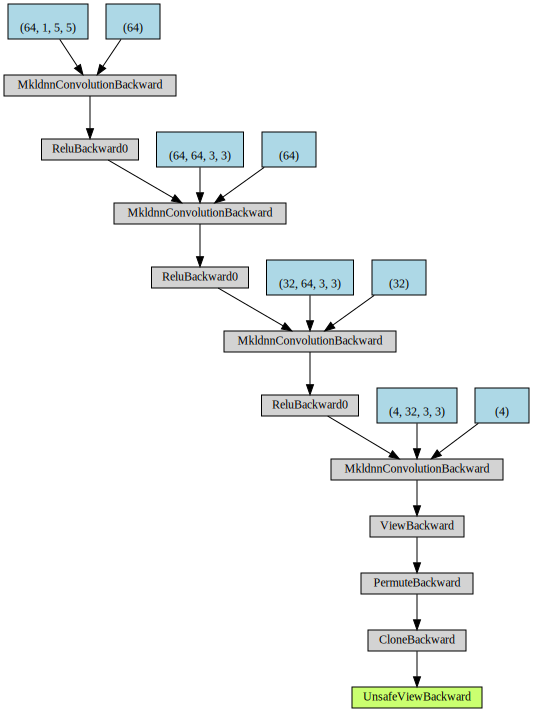

In [14]:
from torchviz import make_dot
make_dot(out) 
#Source(model_arch).render("")

In [8]:
import matplotlib.pyplot as plt
file_name = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/validation/1997.02.07_00:00:00_TAI.fits"
file = fits.open(file_name)
initial = file[0].data
final=denormalize[0][0].detach().numpy()
#image_hist = plt.hist(initial.flatten(), 1000)

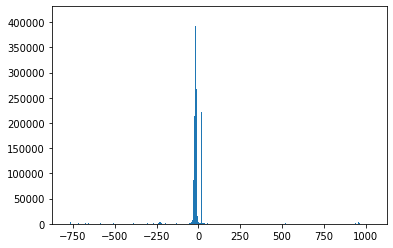

In [9]:
image_hist = plt.hist(final.flatten(), 1000)

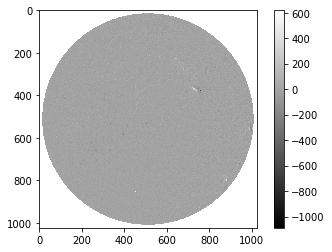

In [10]:
plt.imshow(initial, cmap='gray')
plt.colorbar()

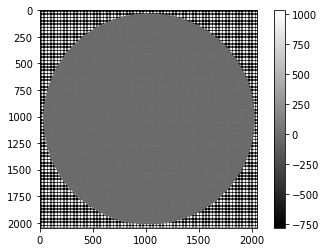

In [11]:
plt.imshow(final, cmap='gray')
plt.colorbar()

In [12]:
outfile = 'ResNet_2k_clip.fits'
final=denormalize[0][0].detach().numpy()
hdu = fits.PrimaryHDU(final)
hdu.writeto(outfile, clobber=True)

In [13]:
PATH = "/home/mhabeeb2/SR/examples/super_resolution/clip_SRCNN.pth"
torch.save(model, PATH)

/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResnetBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type PixelShuffleBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [122]:
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
class Test(ToTensor):
    def __call__(self, pic):
        """
        Args:
            pic (PIL.Image or numpy.ndarray): Image to be converted to tensor.

        Returns:
            Tensor: Converted image.
        """
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            # backward compatibility
            return img.float().div(1500)

        if accimage is not None and isinstance(pic, accimage.Image):
            nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
            pic.copyto(nppic)
            return torch.from_numpy(nppic)

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        # put it from HWC to CHW format
        # yikes, this transpose takes 80% of the loading time/CPU
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(1500)
        else:
            return img

In [123]:
import torch
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader
from os import listdir
from os.path import join
from PIL import Image
from astropy.io import fits
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        Test(),
    ])

def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        Test(),
    ])

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".fits"])

def load_img(filepath):
    image_data = fits.getdata(filepath)
    data = image_data.astype(np.float32)
    a = torch.from_numpy(data)
    a[a != a] = -1 
    a = torch.clamp(a,-1500,1500)
    return a

class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = load_img(self.image_filenames[index])
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)
    
def get_training_set(upscale_factor):
#    root_dir = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits"
    root_dir = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits"
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(4096, upscale_factor)
    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

def get_test_set(upscale_factor):
    root_dir = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits"
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(4096, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

In [19]:
import torch.optim as optim
from math import log10
import numpy as np
model = Net(upscale_factor=3)
criterion = nn.MSELoss()
train_loss = []
test_loss = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_set = get_training_set(3)
training_data_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=10, shuffle=True)
test_set = get_test_set(3)
testing_data_loader = DataLoader(dataset=test_set,  num_workers=2, batch_size=10, shuffle=True)

def train(epoch):
    epoch_loss = 0
    batch_num = 0
    for iteration, batch in enumerate(training_data_loader,1):
        batch[0] = batch[0].unsqueeze(1)
        batch[1] = batch[1].unsqueeze(1)
        input = batch[0]
        target = batch[1]
        input[input != input] = 0
        target[target != target] = 0
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_num += 1
        progress_bar(batch_num , len(training_data_loader), 'Loss: %.4f' % (loss.item()))
#        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))
    l = (epoch , epoch_loss / len(training_data_loader))
    train_loss.append(l)
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

def test():
    avg_psnr = 0
    test_epoch = 0
    batch_num =0 
    with torch.no_grad():
        for batch in testing_data_loader:
            batch[0] = batch[0].unsqueeze(1)
            batch[1] = batch[1].unsqueeze(1)
            input = batch[0]
            target = batch[1]
            input[input != input] = 0
            target[target != target] = 0
            prediction = model(input)
            mse = criterion(prediction, target)
            test_epoch += mse.item()
            psnr = 10 * log10(torch.max(input) / mse.item())
            avg_psnr += psnr
            batch_num += 1
            progress_bar(batch_num, len(testing_data_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))
    m = ( test_epoch / len(testing_data_loader))
    test_loss.append(m)
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
for epoch in range(1, 2):
    train(epoch)
    test()

/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10, 1, 4096, 4096])) that is different to the input size (torch.Size([10, 1, 12288, 12288])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (12288) must match the size of tensor b (4096) at non-singleton dimension 3

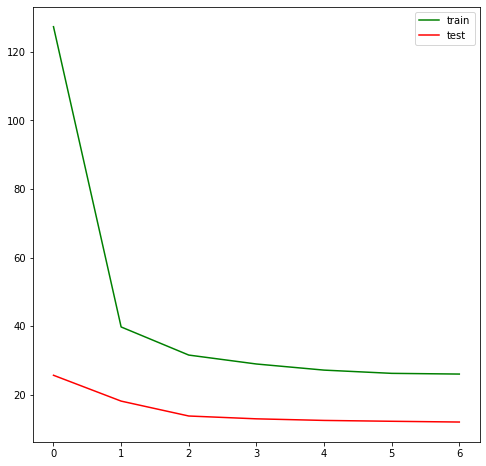

In [18]:
import matplotlib.pyplot as plt
res = [lis[1] for lis in train_loss] 
error = []
#print(test_loss)
#error = test_loss - res
x = range(30),
plt.figure(figsize=(8,8))
plt.plot(res,'g', test_loss, 'r')
plt.legend(['train','test'],loc="upper right")
plt.show()

/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:414: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:414: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


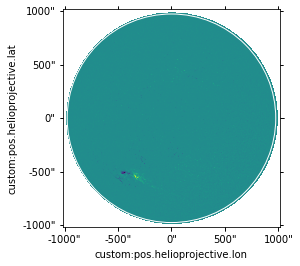

In [13]:
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map.mapbase import GenericMap
from sunpy.map.sources import MDIMap
from sunpy.util.metadata import MetaDict
import numpy as np
import sunpy.map
import matplotlib.pyplot as plt
fig2 = plt.figure()
file_path = "/data/SOHO-MDI/MDI/2010/fd_M_96m_01d.006222/2010.01.14_19:12:00_TAI.fits"
x2 = sunpy.map.Map(file_path)
ax2 = plt.subplot(projection=x2)
ax2.imshow(x2.data)
x2.draw_limb()
plt.show()

In [ ]:
import torch
import torch.utils.data as data

from torch.utils.data import DataLoader
from os import listdir
from os.path import join
from PIL import Image
from astropy.io import fits
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
from astropy.io import fits
filepath1  = "/data/SOHO-MDI/MDI/2010/fd_M_96m_01d.006222/2010.01.14_19:12:00_TAI.fits"
#input_image = "/home/mhabeeb2/DeepLearn/Project/super_resolution/index.jpeg"
#img = Image.open(input_image).convert('YCbCr')
#y, cb, cr = img.split()

#img_to_tensor = ToTensor()
#input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])
#target = input
#og = model(input)
#out_img_y = og[0].detach().numpy()
#print(np.min(out_img_y))
def load_img1(filepath):
    image_data = fits.getdata(filepath)
    data = image_data.astype(np.float32)
    a = torch.from_numpy(data)
    return a
f = load_img1(filepath1)
#print(np.nanmax(y))
#hdu_list = fits.open(filepath)
#hdu_list.info()
#image_data = hdu_list['PRIMARY'].data
#image_data.shape
input1 = f.view(1, 1, f.shape[1], f.shape[0])
#target=torch.nn.functional.upsample_bilinear(input1, size=None, scale_factor=3)
#print(input.shape)
input1[input1 != input1] = 0
#print(input1.shape)
#print(target.shape)

out = model(input1)
#print(out)
out_img_y = out[0].detach().numpy()
print(np.min(out_img_y))
print(np.max(out_img_y))
boundary = np.max(out_img_y)
out_img_y = out_img_y.clip(0, boundary)

#out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map.mapbase import GenericMap
from sunpy.map.sources import MDIMap
from sunpy.util.metadata import MetaDict
import numpy as np
import sunpy.map
import matplotlib.pyplot as plt
fig2 = plt.figure()
x2 = sunpy.map.Map(filepath1)
a = out_img_y.squeeze(0)
ax2 = plt.subplot(projection=x2)
ax2.imshow(a)
x2.draw_limb()
plt.show()